Table of Contents

* <a href='#motivation'>Motivation</a>

* <a href='#constructor'>Constructor</a>

* <a href='#attributes'>Attributes</a>

* <a href='#iteration'>Iteration over samples</a>

* <a href='#subsetselection'>Subset selection</a>

* <a href='#serialization'>Serialization</a>

* <a href='#arithmetic'>Arithmetic</a>

* <a href='#portability'>Portability (e.g. with sklearn)</a>

<a id='motivation'></a>

## A Python data structure to improve handling of datasets in machine learning workflows

This class is greatly suited for neuroimaging applications (or any other domain), where each sample needs to be uniquely identified with a subject ID (or something similar). 

Key-level correspondence across data, labels (1 or 2), classnames ('healthy', 'disease') and the related helps maintain data integrity and improve the provenance, in addition to enabling traceback to original sources from where the features have been originally derived.

Just to given you a concrete examples, let's look at how an ML dataset is handled traditionally.

You have a matrix X of size n x p, with n samples and p features, and a vector y containing the target values (or class labels or class identifiers). This X and y serves as training (and test set) for a classifier like SVM to fit the data X to match y as accurately as possible.

Let's get a little more concrete:

In [40]:
import sys, os
import numpy as np
import matplotlib
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

n = 10 # number of samples
p = 3  # number of features

X = np.random.random([n, p]) # random data for illustration
y = [1]*5 + [2]*5            # random labels ...

np.set_printoptions(precision=2) # save some screen space
print 'X : \n', X
print 'y : \n', y

Using matplotlib backend: Qt4Agg
X : 
[[ 0.17  0.62  0.8 ]
 [ 0.65  0.83  0.55]
 [ 0.59  0.03  0.09]
 [ 0.76  0.27  0.28]
 [ 0.81  0.26  0.68]
 [ 0.77  0.58  0.03]
 [ 0.83  0.2   0.88]
 [ 0.75  0.07  0.43]
 [ 0.53  0.51  0.88]
 [ 0.52  0.48  0.7 ]]
y : 
[1, 1, 1, 1, 1, 2, 2, 2, 2, 2]


Almost all the machine learning toolboxes take their input in this form: X and y, regardless of the original source that produced these features in the first place.

This is all fine if all you ever wanted to do is to extract some features, do some machine learning and dispose these features away! 

** But this is almost never the case!**

Because it doesn't simply end there.

At a minimum, I often need to know 
 * which samples are misclassified - meaning you need to know what the identifiers are and not simply their row indices in X?
 * what are the charecteristics of those samples?
 * what classes do they belong to?


And all this info needs to be obtained
 * without having to write lots of code connecting few non-obvious links to disparate sources of data (numerical features X, and sample identifiers in a CSV file) to find the relevant info
 * without having to track down who or which method originally produced these features
 * how the previous personnel or grad student organized the whole dataset, if you haven't generated the features yourself from scratch

And if you are like me, you would be thinking about how would you organize your workflow such that the aforementioned tasks can be accomplished with ease.
 
This data structure attempts to accomplish that with ease. By always organizing the extracted features keyed-in into a dictionary with their *sample id*, and other important info such as *target values* and other identified info. This, by definition, preserves the integrity of the data (inability to incorrectly label samples etc).

No, this data structure doesn't offer the full [provenance tracking](http://rrcns.readthedocs.io/en/latest/provenance_tracking.html), which is quite a challenging problem. But it tries make your life a little easier in your ML workflows.

An example application is shown below, touching upon the following topics:

* <a href='#constructor'>Constructor</a>

* <a href='#attributes'>Attributes</a>

* <a href='#iteration'>Iteration over samples</a>

* <a href='#subsetselection'>Subset selection</a>

* <a href='#serialization'>Serialization</a>

* <a href='#arithmetic'>Arithmetic</a>

* <a href='#portability'>Portability (e.g. with sklearn)</a>

Improting the necessary modules and our fancy class definition:

In [41]:
from pyradigm import MLDataset

We can now instantiate it and give it a description:

In [42]:
dataset = MLDataset()
dataset.description = 'ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.'

In [43]:
dataset

ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
Empty dataset.

You can see the dataset some description attached to it, however we know it is empty. This can be verified in a boolean context as shown below:

In [44]:
bool(dataset)

False

Let's add samples to this dataset which is when this dataset implementation becomes really handy. Before we do that, we will define some convenience routines defined to just illustrate a simple yet common use of this dataset.

In [45]:
def read_thickness(path):
    """Dummy function to minic a data reader."""

    # in your actural routine, this might be:
    #   pysurfer.read_thickness(path).values()
    return np.random.random(2)


def get_features(work_dir, subj_id):
    """Returns the whole brain cortical thickness for a given subject ID."""

    # extension to identify the data file; this could be .curv, anything else you choose
    ext_thickness = '.thickness'

    thickness = dict()
    for hemi in ['lh', 'rh']:
        path_thickness = os.path.join(work_dir, subj_id, hemi + ext_thickness)
        thickness[hemi] = read_thickness(path_thickness)

    # concatenating them to build a whole brain feature set
    thickness_wb = np.concatenate([thickness['lh'], thickness['rh']])

    return thickness_wb

So now we have IO routines to read the data for us. Let's define where the data will come from:

In [46]:
work_dir = '/project/ADNI/FreesurferThickness_v4p3'
class_set = ['Cntrl', 'Alzmr', 'MCI']
class_sizes = [15, 12, 18]

This would obviously change for your applications, but this has sufficient properties to illustrate the point.

Let's look at what methods this dataset offers us:

In [47]:
dir(dataset)

['add_classes',
 'add_sample',
 'class_set',
 'class_sizes',
 'classes',
 'data',
 'data_matrix',
 'del_sample',
 'description',
 'extend',
 'get_class',
 'get_feature_subset',
 'get_subset',
 'glance',
 'keys',
 'num_classes',
 'num_features',
 'num_samples',
 'random_subset',
 'sample_ids',
 'save',
 'target']

<a id='constructor'></a>

## Constructor

You can see there few methods such as add_sample, get_subset etc: important method being add_sample, which is key to constructing this dataset. Let's go ahead and some samples:

In [48]:
import random
from datetime import datetime
random.seed(datetime.now())

def read_target_list(class_name, class_size):
    "Generates a random target list. In reality, you would do something like the commented code below."
    target_list = list()
    for idx in range(class_size):
        target_list.append('{}{:04d}'.format(class_name[0],np.random.randint(1000)))
        
    return target_list

#     target_list_path = os.path.join(work_dir,'scripts','test_sample.{}'.format(class_name))
#     with open(target_list_path,'r') as tf:
#         target_list = tf.readlines()
#         target_list = [sub.strip() for sub in target_list]

In [49]:
for class_index, class_id in enumerate(class_set):
    print('Working on class {:>5}'.format(class_id))

    target_list = read_target_list(class_id,class_sizes[class_index])
    for subj_id in target_list:
        print('\t reading subject {:>15}'.format(subj_id))
        thickness_wb = get_features(work_dir, subj_id)

        # adding the sample to the dataset
        dataset.add_sample(subj_id, thickness_wb, class_index, class_id)

Working on class Cntrl
	 reading subject           C0521
	 reading subject           C0097
	 reading subject           C0195
	 reading subject           C0846
	 reading subject           C0072
	 reading subject           C0074
	 reading subject           C0299
	 reading subject           C0232
	 reading subject           C0847
	 reading subject           C0427
	 reading subject           C0380
	 reading subject           C0888
	 reading subject           C0078
	 reading subject           C0164
	 reading subject           C0662
Working on class Alzmr
	 reading subject           A0048
	 reading subject           A0060
	 reading subject           A0914
	 reading subject           A0304
	 reading subject           A0339
	 reading subject           A0363
	 reading subject           A0132
	 reading subject           A0645
	 reading subject           A0547
	 reading subject           A0943
	 reading subject           A0266
	 reading subject           A0207
Working on class   MCI
	 reading sub

**Nice. Isn't it?**

So what's nice about this, you say? *The simple fact that you are constructing a dataset as you read the data* in its most elemental form (in the units of the dataset such as the subject ID in our neuroimaging application). You're done as soon as you're done reading the features from disk.

What's more - you can inspect the dataset in an intuitive manner, as shown below:

In [50]:
dataset

ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
45 samples and 4 features.
Class Cntrl : 15 samples.
Class   MCI : 18 samples.
Class Alzmr : 12 samples.

Even better, right? No more too much typing of several commands to get the complete and concise sense of the dataset.

<a id='attributes'></a>

## Convenient attributes

If you would like, you can always get more specific information, such as:

In [51]:
dataset.num_samples

45

In [52]:
dataset.num_features

4

In [53]:
dataset.class_set

{'Alzmr', 'Cntrl', 'MCI'}

In [54]:
dataset.class_sizes

Counter({'Alzmr': 12, 'Cntrl': 15, 'MCI': 18})

In [55]:
dataset.class_sizes['Cntrl']

15

If you'd like to take a look data inside for few subjects - shall we call it a glance?

In [56]:
dataset.glance()

{'C0072': array([ 0.72,  0.8 ,  0.25,  0.97]),
 'C0097': array([ 0.12,  0.6 ,  0.91,  0.95]),
 'C0195': array([ 0.56,  0.1 ,  0.55,  0.35]),
 'C0521': array([ 0.95,  0.3 ,  0.55,  0.29]),
 'C0846': array([ 0.07,  0.64,  0.51,  0.53])}

We can control the number of items to glance, by passing a number to dataset.glance() method:

In [57]:
dataset.glance(2)

{'C0097': array([ 0.12,  0.6 ,  0.91,  0.95]),
 'C0521': array([ 0.95,  0.3 ,  0.55,  0.29])}

Or you may be wondering what are the subject IDs in the dataset.. here they are:

In [58]:
dataset.sample_ids

['C0521',
 'C0097',
 'C0195',
 'C0846',
 'C0072',
 'C0074',
 'C0299',
 'C0232',
 'C0847',
 'C0427',
 'C0380',
 'C0888',
 'C0078',
 'C0164',
 'C0662',
 'A0048',
 'A0060',
 'A0914',
 'A0304',
 'A0339',
 'A0363',
 'A0132',
 'A0645',
 'A0547',
 'A0943',
 'A0266',
 'A0207',
 'M0804',
 'M0084',
 'M0945',
 'M0518',
 'M0940',
 'M0365',
 'M0222',
 'M0441',
 'M0725',
 'M0371',
 'M0801',
 'M0688',
 'M0160',
 'M0404',
 'M0655',
 'M0062',
 'M0836',
 'M0519']

<a id='iteration'></a>

## Iteration over samples

Thanks to its dictionary based implementation, data for a given sample '007_S_1248' can simply be obtained by:

In [59]:
sample_id = dataset.sample_ids[20]
print sample_id, dataset.data[sample_id]

A0363 [ 0.84  0.68  0.07  0.46]


we can easily iterate over all the samples to obtain their data as well as class labels. Let's see it in action:

In [60]:
for sample, features in dataset.data.items():
    print "{} : {:>10} : {}".format(sample, dataset.classes[sample], features)

C0521 :      Cntrl : [ 0.95  0.3   0.55  0.29]
C0097 :      Cntrl : [ 0.12  0.6   0.91  0.95]
C0195 :      Cntrl : [ 0.56  0.1   0.55  0.35]
C0846 :      Cntrl : [ 0.07  0.64  0.51  0.53]
C0072 :      Cntrl : [ 0.72  0.8   0.25  0.97]
C0074 :      Cntrl : [ 0.39  0.03  0.07  0.31]
C0299 :      Cntrl : [ 0.13  0.88  0.8   0.1 ]
C0232 :      Cntrl : [ 0.02  0.62  0.08  0.35]
C0847 :      Cntrl : [ 0.97  0.83  0.71  0.68]
C0427 :      Cntrl : [ 0.27  0.57  0.25  0.59]
C0380 :      Cntrl : [ 0.42  0.22  0.14  0.14]
C0888 :      Cntrl : [ 0.74  0.95  0.27  0.98]
C0078 :      Cntrl : [ 0.28  0.69  0.37  0.61]
C0164 :      Cntrl : [ 0.4   0.51  0.4   0.11]
C0662 :      Cntrl : [ 0.96  0.22  0.04  0.13]
A0048 :      Alzmr : [ 0.38  0.42  0.06  0.11]
A0060 :      Alzmr : [ 0.22  0.89  0.17  0.29]
A0914 :      Alzmr : [ 0.01  0.15  0.43  0.98]
A0304 :      Alzmr : [ 0.9   0.22  0.    0.47]
A0339 :      Alzmr : [ 0.64  0.5   0.67  0.2 ]
A0363 :      Alzmr : [ 0.84  0.68  0.07  0.46]
A0132 :      

Thanks to the choice of the OrderedDict() for each of the data, classes and labels, the order of sample addition is retained. Hence the correspondence across samples in the dataset not only key-wise (by the sample id), but also index-wise.

Another example to illustrate how one can access the subset of features e.g. cortical thickness for a particular region of interest (say posterior cingulate gyrus) is below:

In [61]:
# let's make a function to return the indices for the ROI
def get_ROI_indices(ctx_label=None):
    if ctx_label == 'post_cingulate_gyrus':
        return xrange(2) # dummy for now
    else:
        return xrange(dataset.num_features) # all the features

Now the following code iterates over each sample and prints the average cortical thickness in the specific ROI:

In [62]:
avg_thickness = dict()
for sample, features in dataset.data.items():
    avg_thickness[sample] = np.mean(features[get_ROI_indices('post_cingulate_gyrus')])
    print "{} {:>10}  {:.2f}".format(sample, dataset.classes[sample], avg_thickness[sample] )

C0521      Cntrl  0.62
C0097      Cntrl  0.36
C0195      Cntrl  0.33
C0846      Cntrl  0.36
C0072      Cntrl  0.76
C0074      Cntrl  0.21
C0299      Cntrl  0.50
C0232      Cntrl  0.32
C0847      Cntrl  0.90
C0427      Cntrl  0.42
C0380      Cntrl  0.32
C0888      Cntrl  0.84
C0078      Cntrl  0.48
C0164      Cntrl  0.46
C0662      Cntrl  0.59
A0048      Alzmr  0.40
A0060      Alzmr  0.56
A0914      Alzmr  0.08
A0304      Alzmr  0.56
A0339      Alzmr  0.57
A0363      Alzmr  0.76
A0132      Alzmr  0.60
A0645      Alzmr  0.34
A0547      Alzmr  0.81
A0943      Alzmr  0.43
A0266      Alzmr  0.50
A0207      Alzmr  0.36
M0804        MCI  0.43
M0084        MCI  0.81
M0945        MCI  0.59
M0518        MCI  0.74
M0940        MCI  0.27
M0365        MCI  0.68
M0222        MCI  0.73
M0441        MCI  0.53
M0725        MCI  0.41
M0371        MCI  0.08
M0801        MCI  0.70
M0688        MCI  0.70
M0160        MCI  0.53
M0404        MCI  0.86
M0655        MCI  0.65
M0062        MCI  0.74
M0836      

Let's make a bar plot with the just computed numbers:

In [63]:
avg_thickness.values()

[0.20828357773861217,
 0.75855481225358801,
 0.35969326688292214,
 0.6759115652357176,
 0.4818775555718694,
 0.39634091997594362,
 0.86307529531573035,
 0.55668829695017452,
 0.45693408819469711,
 0.55752594793326526,
 0.74104242282296784,
 0.54989676544637989,
 0.70492586478718477,
 0.34250331698673958,
 0.43084823279734125,
 0.31924955446818032,
 0.76108599112941877,
 0.58520892910233835,
 0.2714500820505506,
 0.42729278990200026,
 0.41955539057127744,
 0.53414583423011819,
 0.082471414289991885,
 0.52840772865515762,
 0.80740043893044477,
 0.73725807678203437,
 0.075305533117054568,
 0.62329444259653555,
 0.58902769011073119,
 0.329880617604145,
 0.59830751815668781,
 0.49809014419921327,
 0.57075014953794412,
 0.41091825737010768,
 0.69586104344867072,
 0.32196134103385143,
 0.35529354358654569,
 0.81051757625010179,
 0.50303578284141759,
 0.72748460530019976,
 0.64663513739419853,
 0.35701920701003542,
 0.77397417189390749,
 0.84499071643523038,
 0.90151247091865372]

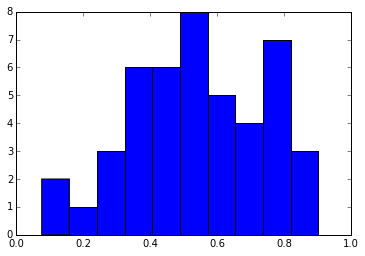

In [64]:
n, bins, patches = plt.hist(avg_thickness.values())

Remember as the original source of data was random, this has no units, property or meaning!

<a id='subsetselection'></a>

## Subset selection

In addition to the structured way of obtaining the various properties of this dataset, this implementation really will come in handy when you have to slice and dice the dataset (with large number of classes and features) into smaller subsets (e.g. for binary classification). Let's see how we can retrieve the data for a single class:

In [65]:
ctrl = dataset.get_class('Cntrl')

That's it, obtaining the data for a given class is a simple call away.

Now let's see what it looks like:

In [66]:
ctrl


 Subset derived from: ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
15 samples and 4 features.
Class Cntrl : 15 samples.

Even with updated description automatically, to indicate its history. Let's see some data from controls:

In [67]:
ctrl.glance(2)

{'C0097': array([ 0.12,  0.6 ,  0.91,  0.95]),
 'C0521': array([ 0.95,  0.3 ,  0.55,  0.29])}

We can also query a random subset of samples for manual inspection or cross-validation purposes. For example:

In [68]:
random_subset = dataset.random_subset(perc_per_class=0.3)
random_subset


 Subset derived from: ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
14 samples and 4 features.
Class Cntrl : 5 samples.
Class   MCI : 5 samples.
Class Alzmr : 4 samples.

You can see which samples were selected:

In [69]:
random_subset.sample_ids

['C0097',
 'C0299',
 'C0427',
 'C0380',
 'C0078',
 'A0048',
 'A0645',
 'A0943',
 'A0266',
 'M0804',
 'M0518',
 'M0441',
 'M0725',
 'M0371']

You can verify that it is indeed random by issuing another call:

In [79]:
# supplying a new seed everytime to ensure randomization
from datetime import datetime
dataset.random_subset(perc_per_class=0.3, random_seed=datetime.now()).sample_ids

['C0521',
 'C0097',
 'C0299',
 'C0847',
 'C0888',
 'A0339',
 'A0645',
 'A0547',
 'A0266',
 'M0804',
 'M0945',
 'M0518',
 'M0222',
 'M0062']

#### Let's see how we can retrieve specific samples by their IDs (for which there are many use cases):

In [84]:
data = dataset.get_subset(dataset.sample_ids[1:20])
data


 Subset derived from: ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
19 samples and 4 features.
Class Cntrl : 14 samples.
Class Alzmr : 5 samples.

So as simple as that.

#### More useful case would be to select a subset of classes from an original large dataset:

In [85]:
dataset

ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
45 samples and 4 features.
Class Cntrl : 15 samples.
Class   MCI : 18 samples.
Class Alzmr : 12 samples.

In [90]:
binary_dataset = dataset.get_class(['Cntrl','Alzmr'])
binary_dataset


 Subset derived from: ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
27 samples and 4 features.
Class Cntrl : 15 samples.
Class Alzmr : 12 samples.

How about selecting a subset of features from all samples?

In [91]:
binary_dataset.get_feature_subset(xrange(2))

Subset features derived from: 
 
 Subset derived from: ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
27 samples and 2 features.
Class Cntrl : 15 samples.
Class Alzmr : 12 samples.

**Great.** Isn't it? You can also see the two-time-point history (initial subset in classes, followed by a subset in features).

<a id='serialization'></a>

## Serialization

Once you have this dataset, you can save and load these trivially using your favourite serialization module. Let's do some pickling:

In [92]:
out_file = os.path.join(work_dir,'binary_dataset_Ctrl_Alzr_Freesurfer_thickness_v4p3.pkl')
binary_dataset.save(out_file)

IOError: [Errno Unable to read the dataset from file: {}] [Errno 2] No such file or directory: '/project/ADNI/FreesurferThickness_v4p3/binary_dataset_Ctrl_Alzr_Freesurfer_thickness_v4p3.pkl'

That's it - it is saved.

Let's reload it from disk and make sure we can indeed retrieve it:

In [ ]:
reloaded = MLDataset(filepath=out_file) # another form of the constructor!

In [ ]:
reloaded

<a id='arithmetic'></a>

## Dataset Arithmetic

You might wonder how can you combine two different types of features ( thickness and shape ) from the dataset. Piece of cake, see below ...

To concatenat two datasets, first we make a second dataset:

In [ ]:
dataset_two = MLDataset(in_dataset=dataset) # yet another constructor: in its copy form!

How can you check if they are "functionally identical"? As in same keys, same data and classes for each key... Easy:

In [ ]:
dataset_two == dataset

Now let's try the arithmentic:

In [ ]:
combined = dataset + dataset_two

Great. The add method recognized the identical set of keys and performed a horiz cat, as can be noticed by the twice the number of features in the combined dataset:

In [ ]:
combined

We can also do some removal in similar fashion:

In [ ]:
smaller = combined - dataset

Data structure is even producing a warning to let you know the resulting output would be empty! We can verify that:

In [ ]:
bool(smaller)

<a id='portability'></a>

## Portability

This is all well and good. How does it interact with other packages out there, you might ask? It is as simple as you can imagine:

In [ ]:
from sklearn import svm
clf = svm.SVC(gamma=0.001, C=100.)

In [ ]:
clf.fit(binary_dataset.data_matrix, binary_dataset.target)

There you have it, a simple example to show you the utility and convenience of this dataset.

### Thanks for checking it out. 

### I would appreciate if you could give me feedback on improving or sharpening it further.